In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os

In [2]:
# Turn off setting with copy warning
pd.set_option('mode.chained_assignment', None)

In [3]:
from notify_run import Notify

In [4]:
notify = Notify()

In [5]:
notify.register()

Endpoint: https://notify.run/FW0184a2Ruvwol5g
To subscribe, open: https://notify.run/c/FW0184a2Ruvwol5g
Or scan this QR code:

                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              

In [6]:
os.chdir('../data/interim')

In [7]:
os.listdir()

['.gitkeep',
 'data post-eda.csv',
 'joined data full.csv',
 'joined data post-markdowns.csv',
 'joined data pre-markdowns.csv']

## Final Pre-Processing

My approach is going to be dropping the markdown columns in order to have access to the entire data set for training.

In [8]:
# Loading full joined data as df
df = pd.read_csv('data post-eda.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1


In [9]:
# Dropping markdown columns
df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [10]:
# Show info of remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  int64  
 10  Size          421570 non-null  int64  
 11  Month         421570 non-null  int64  
 12  Week          421570 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 41.8+ MB


Columns that should have dummy features encoded:
- Store
- Dept
- Type
- Month
- Week

In [11]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,211.671989,7.838,2,151315,1,1


##### I plan to create 3 separate models. One for each of the different store types.

In [12]:
# Create dummy features
deptDummies = pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)
monthDummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
weekDummies = pd.get_dummies(df['Week'], prefix='Week', drop_first=True)

In [13]:
# Join dummy features onto dataframe
df = df.join([deptDummies, monthDummies, weekDummies])

In [14]:
# Drop original features
df.drop(columns=['Dept', 'Month', 'Week'], inplace=True)

In [15]:
# Split the data by 3 store types
df0 = df.loc[df.Type == 0]
df1 = df.loc[df.Type == 1]
df2 = df.loc[df.Type == 2]

In [16]:
# Drop Type and Date features
df0 = df0.drop(columns=['Type'])
df1 = df1.drop(columns=['Type'])
df2 = df2.drop(columns=['Type'])

In [17]:
# Create Store Dummy Features
storeDummies0 = pd.get_dummies(df0['Store'], prefix='Store', drop_first=True)
storeDummies1 = pd.get_dummies(df1['Store'], prefix='Store', drop_first=True)
storeDummies2 = pd.get_dummies(df2['Store'], prefix='Store', drop_first=True)

In [18]:
# Join Store dummes to dataframes
df0 = df0.join(storeDummies0)
df1 = df1.join(storeDummies1)
df2 = df2.join(storeDummies2)

In [19]:
# Drop Store columns from dataframes
df0 = df0.drop(columns=['Store'])
df1 = df1.drop(columns=['Store'])
df2 = df2.drop(columns=['Store'])

In [20]:
# Print dataframe shapes
print(df0.shape)
print(df1.shape)
print(df2.shape)

(42597, 155)
(163495, 166)
(215478, 171)


## Train Test Split and Cross-Validation Train Test Split

We want to perform a train test split prior to scaling the data

In [21]:
# Create masks
trainmask0 = df0.Date < '2012-01-01'
testmask0 = df0.Date >= '2012-01-01'
trainmask1 = df1.Date < '2012-01-01'
testmask1 = df1.Date >= '2012-01-01'
trainmask2 = df2.Date < '2012-01-01'
testmask2 = df2.Date >= '2012-01-01'

# Split into sets by masks
dftrain0 = df0.loc[trainmask0]
dftest0 = df0.loc[testmask0]
dftrain1 = df1.loc[trainmask1]
dftest1 = df1.loc[testmask1]
dftrain2 = df2.loc[trainmask2]
dftest2 = df2.loc[testmask2]

Scaler transformation for continuous feature variables

In [22]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Initialize scaler and fit_transform X_train
scaler0 = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
dftrain0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.fit_transform(dftrain0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
dftrain1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.fit_transform(dftrain1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
dftrain2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.fit_transform(dftrain2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

In [24]:
# Verify that tranformation was successful
dftrain0.head()

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Dept_2,Dept_3,...,Week_48,Week_49,Week_50,Week_51,Week_52,Store_37,Store_38,Store_42,Store_43,Store_44
1993,2010-01-10,9843.45,0,0.648274,0.052725,0.915722,0.253188,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,2010-01-10,13898.10,0,0.648274,0.052725,0.915722,0.253188,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1995,2010-01-10,755.67,0,0.648274,0.052725,0.915722,0.253188,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1996,2010-01-10,13610.70,0,0.648274,0.052725,0.915722,0.253188,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,2010-01-10,444.76,0,0.648274,0.052725,0.915722,0.253188,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Apply scaler transformation to test data
dftest0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.transform(dftest0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
dftest1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.transform(dftest1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
dftest2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.transform(dftest2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

Split X from y

In [26]:
# Test train split
X_train0 = dftrain0.drop(columns=['Date', 'Weekly_Sales'])
y_train0 = dftrain0[['Weekly_Sales']]
X_test0 = dftest0.drop(columns=['Date', 'Weekly_Sales'])
y_test0 = dftest0[['Weekly_Sales']]
X_train1 = dftrain1.drop(columns=['Date', 'Weekly_Sales'])
y_train1 = dftrain1[['Weekly_Sales']]
X_test1 = dftest1.drop(columns=['Date', 'Weekly_Sales'])
y_test1 = dftest1[['Weekly_Sales']]
X_train2 = dftrain2.drop(columns=['Date', 'Weekly_Sales'])
y_train2 = dftrain2[['Weekly_Sales']]
X_test2 = dftest2.drop(columns=['Date', 'Weekly_Sales'])
y_test2 = dftest2[['Weekly_Sales']]

Let's define a function for splitting the training data into segments in order to perform cross-validation on models later.

In [27]:
def cvsplit(df):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    # Create masks for 5-fold CV
    trainm1 = df.Date < '2011-01-01'
    testm1 = (df.Date >= '2011-01-01') & (df.Date < '2011-03-01')
    trainm2 = df.Date < '2011-03-01'
    testm2 = (df.Date >= '2011-03-01') & (df.Date < '2011-05-01')
    trainm3 = df.Date < '2011-05-01'
    testm3 = (df.Date >= '2011-05-01') & (df.Date < '2011-07-01')
    trainm4 = df.Date < '2011-07-01'
    testm4 = (df.Date >= '2011-07-01') & (df.Date < '2011-09-01')
    trainm5 = df.Date < '2011-09-01'
    testm5 = (df.Date >= '2011-09-01') & (df.Date < '2012-01-01')
    
    # Split into sets by masks
    dftrain1 = df.loc[trainm1]
    dftest1 = df.loc[testm1]    
    dftrain2 = df.loc[trainm2]
    dftest2 = df.loc[testm2]   
    dftrain3 = df.loc[trainm3]
    dftest3 = df.loc[testm3]   
    dftrain4 = df.loc[trainm4]
    dftest4 = df.loc[testm4]   
    dftrain5 = df.loc[trainm5]
    dftest5 = df.loc[testm5]
    
    # Test train split and append to lists
    X_train.append(dftrain1.drop(columns=['Date', 'Weekly_Sales']))
    y_train.append(dftrain1[['Weekly_Sales']])
    X_test.append(dftest1.drop(columns=['Date', 'Weekly_Sales']))
    y_test.append(dftest1[['Weekly_Sales']])
    
    X_train.append(dftrain2.drop(columns=['Date', 'Weekly_Sales']))
    y_train.append(dftrain2[['Weekly_Sales']])
    X_test.append(dftest2.drop(columns=['Date', 'Weekly_Sales']))
    y_test.append(dftest2[['Weekly_Sales']])
    
    X_train.append(dftrain3.drop(columns=['Date', 'Weekly_Sales']))
    y_train.append(dftrain3[['Weekly_Sales']])
    X_test.append(dftest3.drop(columns=['Date', 'Weekly_Sales']))
    y_test.append(dftest3[['Weekly_Sales']])
    
    X_train.append(dftrain4.drop(columns=['Date', 'Weekly_Sales']))
    y_train.append(dftrain4[['Weekly_Sales']])
    X_test.append(dftest4.drop(columns=['Date', 'Weekly_Sales']))
    y_test.append(dftest4[['Weekly_Sales']])
    
    X_train.append(dftrain5.drop(columns=['Date', 'Weekly_Sales']))
    y_train.append(dftrain5[['Weekly_Sales']])
    X_test.append(dftest5.drop(columns=['Date', 'Weekly_Sales']))
    y_test.append(dftest5[['Weekly_Sales']])
    
    # Return CV test train lists
    return X_train, y_train, X_test, y_test

In [28]:
# Create cross-validation sets
cvX_train0, cvy_train0, cvX_test0, cvy_test0 = cvsplit(dftrain0)
cvX_train1, cvy_train1, cvX_test1, cvy_test1 = cvsplit(dftrain1)
cvX_train2, cvy_train2, cvX_test2, cvy_test2 = cvsplit(dftrain2)

In [39]:
# Additional method is creating a cross-validation parameter to be used in GridSearchCV
# Import GridSearchCV as well
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

In [106]:
# Create a standard GridSearchCV Function to use in addition to the CV function I build
def GSCV(reg, param_grid, store):
    if store == 0:
        X_train, y_train, X_test, y_test = X_train0, y_train0, X_test0, y_test0
    elif store == 1:
        X_train, y_train, X_test, y_test = X_train1, y_train1, X_test1, y_test1
    else:
        X_train, y_train, X_test, y_test = X_train2, y_train2, X_test2, y_test2
        
    gscv = GridSearchCV(estimator=reg, cv=tscv, param_grid=param_grid, \
                        scoring='neg_root_mean_squared_error')
    gscv.fit(X_train, np.ravel(y_train))
    print('Best parameters are ' + str(gscv.best_params_))
    print('Best RMSE score is ' + str(round(-gscv.best_score_)))    

In [107]:
# Create a RandomizedSearchCV Function as well to use with the more computationally intenstive algorithms
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
def RSCV(reg, param_dist, store, n_iter=10):
    if store == 0:
        X_train, y_train, X_test, y_test = X_train0, y_train0, X_test0, y_test0
    elif store == 1:
        X_train, y_train, X_test, y_test = X_train1, y_train1, X_test1, y_test1
    else:
        X_train, y_train, X_test, y_test = X_train2, y_train2, X_test2, y_test2
        
    rscv = RandomizedSearchCV(estimator=reg, n_iter=n_iter, cv=tscv, param_distributions=param_dist, \
                        scoring='neg_root_mean_squared_error')
    rscv.fit(X_train, np.ravel(y_train))
    print('Best parameters are ' + str(rscv.best_params_))
    print('Best RMSE score is ' + str(round(-rscv.best_score_)))    

## Modeling


### Linear Regression

In [30]:
# Import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [31]:
# Build function for cross-validation modeling
def cvmodeling(model, X_train, y_train, X_test, y_test, table=False):
    
    # Instantiate empty lists
    cvnum = []
    R2_train = []
    R2_test = []
    RMSE_test = []
    
    # For loop to collect parameters
    for i in range(5):
        reg = model
        reg.fit(X_train[i], np.ravel(y_train[i]))
        y_pred = reg.predict(X_test[i])
        cvnum.append(i+1)
        R2_train.append(round(reg.score(X_train[i], np.ravel(y_train[i])), 4))
        R2_test.append(round(r2_score(y_test[i], y_pred), 4))
        RMSE_test.append(round(mean_squared_error(y_test[i], y_pred, squared=False), 4))
    
    summary = pd.DataFrame({'CV_num':cvnum, 'R2_train_score':R2_train, 'R2_test_score':R2_test, 'RMSE_test_score':RMSE_test})
    if table == True:
        print(summary)
    print('Mean CV R2 training score = ' + str(round(summary.R2_train_score.mean(), 4)))
    print('Mean CV R2 testing score = ' + str(round(summary.R2_test_score.mean(), 4)))
    print('Mean CV Root-mean-squared test score = ' + str(round(summary.RMSE_test_score.mean())))

Let's try a standard linear regression to start

In [32]:
# Import module
from sklearn.linear_model import LinearRegression

In [33]:
# Define function for linear regression cross validation
def linregCV(store, table=False):
        linreg = LinearRegression()
        print('LinearRegression - CV - Store Type ' + str(store))
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(linreg, X_train, y_train, X_test, y_test, table)
        print('\n')

In [34]:
%%time
# Linear Regression CV on Store Type 0
linregCV(0, True)

LinearRegression - CV - Store Type 0
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.8966  -3.791204e+24     3.004639e+16
1       2          0.9000  -6.480850e+23     1.264206e+16
2       3          0.9018  -1.313542e+22     1.798878e+15
3       4          0.9024  -6.076139e+21     1.241335e+15
4       5          0.9018  -5.293005e+21     1.175911e+15
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = -8.927586343701596e+23
Mean CV Root-mean-squared test score = 9380916230047378


Wall time: 898 ms


In [35]:
%%time
# Linear Regression CV on Store Type 1
linregCV(1, True)

LinearRegression - CV - Store Type 1
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.6331  -2.067003e+24     2.292225e+16
1       2          0.6427  -7.095726e+24     4.241503e+16
2       3          0.6517  -5.730013e+20     3.688910e+14
3       4          0.6575  -3.389901e+24     2.880930e+16
4       5          0.6643  -7.754588e+22     5.542422e+15
Mean CV R2 training score = 0.6499
Mean CV R2 testing score = -2.5261497983843974e+24
Mean CV Root-mean-squared test score = 20011577119268792


Wall time: 3.95 s


In [36]:
%%time
# Linear Regression CV on Store Type 2
linregCV(2, True)

LinearRegression - CV - Store Type 2
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.7888  -3.126525e+24     4.424536e+16
1       2          0.7952  -7.820331e+24     7.153989e+16
2       3          0.8003  -9.655305e+21     2.484896e+15
3       4          0.8040  -3.452033e+24     4.804678e+16
4       5          0.8080  -1.094594e+24     2.998432e+16
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = -3.1006275775466636e+24
Mean CV Root-mean-squared test score = 39260248553684576


Wall time: 5.73 s


### Ridge Regression.

In [40]:
# Import module
from sklearn.linear_model import Ridge

In [41]:
# Define function for performing ridge regression cross validation for tuning of alpha

def ridgeregCV(store, alphas, table=False):
    for i in alphas:
        ridgereg = Ridge(random_state=42, alpha=i)
        print('Ridge Regression - CV - alpha=' + str(i) + ' - Store Type ' + str(store))
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(ridgereg, X_train, y_train, X_test, y_test, table)
        print('\n')

In [42]:
%%time
ridgeregCV(0, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9051
Mean CV Root-mean-squared test score = 4862


Ridge Regression - CV - alpha=0.01 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9054
Mean CV Root-mean-squared test score = 4854


Ridge Regression - CV - alpha=0.1 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9061
Mean CV Root-mean-squared test score = 4836


Ridge Regression - CV - alpha=1 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9061
Mean CV Root-mean-squared test score = 4836


Ridge Regression - CV - alpha=10 - Store Type 0
Mean CV R2 training score = 0.8995
Mean CV R2 testing score = 0.9038
Mean CV Root-mean-squared test score = 4896


Ridge Regression - CV - alpha=100 - Store Type 0
Mean CV R2 training score = 0.8581
Mean CV R2 testing score = 0.8555
Mean CV Root-mean-squared test score = 5998


Ridge Regression

In [57]:
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 0)

Best parameters are {'alpha': 0.1}
Best score is 0.8988


In [48]:
%%time
ridgeregCV(1, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6559
Mean CV Root-mean-squared test score = 9718


Ridge Regression - CV - alpha=0.01 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6579
Mean CV Root-mean-squared test score = 9693


Ridge Regression - CV - alpha=0.1 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6678
Mean CV Root-mean-squared test score = 9572


Ridge Regression - CV - alpha=1 - Store Type 1
Mean CV R2 training score = 0.6499
Mean CV R2 testing score = 0.6767
Mean CV Root-mean-squared test score = 9456


Ridge Regression - CV - alpha=10 - Store Type 1
Mean CV R2 training score = 0.6492
Mean CV R2 testing score = 0.6805
Mean CV Root-mean-squared test score = 9405


Ridge Regression - CV - alpha=100 - Store Type 1
Mean CV R2 training score = 0.642
Mean CV R2 testing score = 0.6825
Mean CV Root-mean-squared test score = 9380


Ridge Regression - CV -

In [58]:
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 1)

Best parameters are {'alpha': 1}
Best score is 0.6364


In [50]:
%%time
ridgeregCV(2, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8166
Mean CV Root-mean-squared test score = 11174


Ridge Regression - CV - alpha=0.01 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8168
Mean CV Root-mean-squared test score = 11169


Ridge Regression - CV - alpha=0.1 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8173
Mean CV Root-mean-squared test score = 11151


Ridge Regression - CV - alpha=1 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8177
Mean CV Root-mean-squared test score = 11141


Ridge Regression - CV - alpha=10 - Store Type 2
Mean CV R2 training score = 0.799
Mean CV R2 testing score = 0.8176
Mean CV Root-mean-squared test score = 11145


Ridge Regression - CV - alpha=100 - Store Type 2
Mean CV R2 training score = 0.7936
Mean CV R2 testing score = 0.8117
Mean CV Root-mean-squared test score = 11324


Ridge Regre

In [59]:
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 2)

Best parameters are {'alpha': 1}
Best score is 0.7844


### Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
# Define function for performing random forest cross validation for tuning of max_depth

def rfCV(store, tuneparam=None, param_value=None, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
         min_weight_fraction_leaf=0, n_jobs=-1, max_features='auto', table=False):
    if param_value == None:
        
        rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, \
                                      min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction, \
                                      max_features=max_features, n_jobs=n_jobs)
        
        print('Random Forest Regression - CV - Store Type ' + str(store))
        print('max_depth = ' + str(max_depth))
        print('min_samples_split = ' + str(min_samples_split))
        print('min_samples_leaf = ' + str(min_samples_leaf))
        print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
        print('max_features = ' + str(max_features))
        
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(rfreg, X_train, y_train, X_test, y_test, table)
        print('\n')
        
    else:
        for i in param_value:
        
            if tuneparam == 'max_depth':
                rfreg = RandomForestRegressor(random_state=42, max_depth=i, min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(i))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))                
                
            elif tuneparam == 'min_samples_split':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=i, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(i))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))
                
            elif tuneparam == 'min_samples_leaf':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=i, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(i))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))  
                
            elif tuneparam == 'min_weight_fraction_leaf':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=i, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(i))
                print('max_features = ' + str(max_features))
                
            elif tuneparam == 'max_features':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=i, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(i))
            
       
            if store == 0:
                X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
            elif store ==1:
                X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
            else:
                X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
            cvmodeling(rfreg, X_train, y_train, X_test, y_test, table)
            print('\n')

#### Store Type 0

In [38]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 0
rfCV(store=0, tuneparam='max_depth', param_value=[20, 40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 0
max_depth = 20
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9893
Mean CV R2 testing score = 0.9749
Mean CV Root-mean-squared test score = 2494


Random Forest Regression - CV - Store Type 0
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9921
Mean CV R2 testing score = 0.9767
Mean CV Root-mean-squared test score = 2400


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9975
Mean CV R2 testing score = 0.9805
Mean CV Root-mean-squared test score = 2190


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9981
Mean CV R2 t

##### Let's use max_depth = 60

In [63]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 0
rfCV(store=0, tuneparam='min_samples_split', param_value=[2, 5, 10, 15, 20, 25, 30, 35, 40], max_depth=60)

Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9975
Mean CV R2 testing score = 0.9805
Mean CV Root-mean-squared test score = 2190


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9969
Mean CV R2 testing score = 0.9804
Mean CV Root-mean-squared test score = 2194


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9957
Mean CV R2 testing score = 0.9806
Mean CV Root-mean-squared test score = 2184


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9945
Mean CV R2

##### Let's use min_samples_split = 10

In [67]:
%%time
# CV hyperparameter tuning of min_samples_leaf for Store Type 0
rfCV(store=0, tuneparam='min_samples_leaf', param_value=[1, 5, 10, 15, 20], max_depth=60, min_samples_split=10)

Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9957
Mean CV R2 testing score = 0.9806
Mean CV Root-mean-squared test score = 2184


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 5
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9917
Mean CV R2 testing score = 0.9788
Mean CV Root-mean-squared test score = 2283


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 10
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9888
Mean CV R2 testing score = 0.978
Mean CV Root-mean-squared test score = 2325


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 15
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9875
Mean CV

##### Let's use min_samples_leaf = 1

In [71]:
%%time
# CV hyperparameter tuning of min_weight_fraction_leaf for Store Type 0
rfCV(store=0, tuneparam='min_weight_fraction_leaf', param_value=[0, 0.0001, 0.0005, 0.001, 0.005], max_depth=60, \
     min_samples_split=10, min_samples_leaf=1)

Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9957
Mean CV R2 testing score = 0.9806
Mean CV Root-mean-squared test score = 2184


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0001
max_features = auto
Mean CV R2 training score = 0.9945
Mean CV R2 testing score = 0.98
Mean CV Root-mean-squared test score = 2214


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0005
max_features = auto
Mean CV R2 training score = 0.9907
Mean CV R2 testing score = 0.9784
Mean CV Root-mean-squared test score = 2305


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.001
max_features = auto
Mean CV R2 training score = 0.9

##### We'll leave min_weight_fraction_leaf = 0

In [72]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 0
rfCV(store=0, tuneparam='max_features', param_value=['auto', 'sqrt', 'log2'], max_depth=60, \
     min_samples_split=10, min_samples_leaf=1, min_weight_fraction_leaf=0)

Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9957
Mean CV R2 testing score = 0.9806
Mean CV Root-mean-squared test score = 2184


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = sqrt
Mean CV R2 training score = 0.9899
Mean CV R2 testing score = 0.9747
Mean CV Root-mean-squared test score = 2505


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = log2
Mean CV R2 training score = 0.9769
Mean CV R2 testing score = 0.957
Mean CV Root-mean-squared test score = 3269


Wall time: 1min 6s


##### We'll leave max_features as 'auto'

In [95]:
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(2, 10, 1), \
              'min_samples_leaf':np.arange(1, 10, 1), \
              'max_features':['auto', 'sqrt', 'log2']}
RSCV(RandomForestRegressor(n_jobs=-2), param_grid, 0, n_iter=20)

Best parameters are {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60}
Best RMSE score is 2232.5883


In [108]:
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(2, 10, 1), \
              'min_samples_leaf':np.arange(1, 10, 1), \
              'max_features':['auto', 'sqrt', 'log2']}
RSCV(RandomForestRegressor(n_jobs=-1), param_grid, 0, n_iter=20)

Best parameters are {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 70}
Best RMSE score is 2287.0


In [109]:
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(2, 10, 1), \
              'min_samples_leaf':np.arange(1, 10, 1), \
              'max_features':['auto', 'sqrt', 'log2']}
RSCV(RandomForestRegressor(n_jobs=-1), param_grid, 0, n_iter=10)

Best parameters are {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 60}
Best RMSE score is 2289.0


In [110]:
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(60, 80, 5), \
              'min_samples_split':np.arange(2, 10, 1), \
              'min_samples_leaf':np.arange(1, 10, 1)}
RSCV(RandomForestRegressor(n_jobs=-1), param_grid, 0, n_iter=20)

Best parameters are {'min_samples_split': 9, 'min_samples_leaf': 1, 'max_depth': 70}
Best RMSE score is 2205.0


In [111]:
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(60, 70, 1), \
              'min_samples_split':np.arange(3, 15, 1), \
              'min_samples_leaf':np.arange(1, 10, 1)}
RSCV(RandomForestRegressor(n_jobs=-1), param_grid, 0, n_iter=20)

Best parameters are {'min_samples_split': 14, 'min_samples_leaf': 1, 'max_depth': 66}
Best RMSE score is 2209.0


#### Store Type 1

In [76]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 1
rfCV(store=1, tuneparam='max_depth', param_value=[20, 40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 1
max_depth = 20
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8677
Mean CV R2 testing score = 0.8024
Mean CV Root-mean-squared test score = 7243


Random Forest Regression - CV - Store Type 1
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9543
Mean CV R2 testing score = 0.8645
Mean CV Root-mean-squared test score = 5730


Random Forest Regression - CV - Store Type 1
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.968
Mean CV R2 testing score = 0.8672
Mean CV Root-mean-squared test score = 5538


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.983
Mean CV R2 tes

##### Let's use max_depth = 80

In [78]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 1
rfCV(store=1, tuneparam='min_samples_split', param_value=[2, 5, 10, 15, 20, 25, 30, 35, 40], max_depth=80)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.983
Mean CV R2 testing score = 0.8699
Mean CV Root-mean-squared test score = 5349


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9779
Mean CV R2 testing score = 0.8802
Mean CV Root-mean-squared test score = 5191


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9645
Mean CV R2 testing score = 0.8814
Mean CV Root-mean-squared test score = 5222


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9493
Mean CV R2 

##### min_samples_split=35 worked well

##### Let's try keeping min_samples_split = 2 and doing the CV tuning on min_samples_leaf

In [83]:
%%time
# CV hyperparameter tuning of min_samples_leaf for Store Type 1
rfCV(store=1, tuneparam='min_samples_leaf', param_value=[5, 10, 15, 20], max_depth=80, min_samples_split=2)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 5
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9419
Mean CV R2 testing score = 0.8813
Mean CV Root-mean-squared test score = 5424


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 10
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9062
Mean CV R2 testing score = 0.8524
Mean CV Root-mean-squared test score = 6031


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 15
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8774
Mean CV R2 testing score = 0.8129
Mean CV Root-mean-squared test score = 6685


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 20
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8607
Mean CV R

##### Let's leaf min_samples_leaf=1 and set min_samples_split=35

In [41]:
%%time
# CV hyperparameter tuning of min_weight_fraction_leaf for Store Type 1
rfCV(store=1, tuneparam='min_weight_fraction_leaf', param_value=[0.0001, 0.0005, 0.001, 0.005], max_depth=80, \
     min_samples_split=35, min_samples_leaf=1)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0001
max_features = auto
Mean CV R2 training score = 0.9104
Mean CV R2 testing score = 0.8865
Mean CV Root-mean-squared test score = 5427


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0005
max_features = auto
Mean CV R2 training score = 0.8517
Mean CV R2 testing score = 0.7925
Mean CV Root-mean-squared test score = 7143


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.001
max_features = auto
Mean CV R2 training score = 0.751
Mean CV R2 testing score = 0.6868
Mean CV Root-mean-squared test score = 9099


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.005
max_features = auto
Mean CV R2 training score 

##### Leaving min_weight_fraction_leaf=0

In [43]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 1
rfCV(store=1, tuneparam='max_features', param_value=['auto', 'sqrt', 'log2'], max_depth=80, \
     min_samples_split=35, min_samples_leaf=1, min_weight_fraction_leaf=0)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9305
Mean CV R2 testing score = 0.9009
Mean CV Root-mean-squared test score = 5049


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = sqrt
Mean CV R2 training score = 0.8883
Mean CV R2 testing score = 0.8715
Mean CV Root-mean-squared test score = 5818


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = log2
Mean CV R2 training score = 0.8598
Mean CV R2 testing score = 0.8541
Mean CV Root-mean-squared test score = 6249


Wall time: 6min 10s


##### Leaving max_features='auto'

##### Not bad, but we'll try to improve it through additional measures later


#### Store Type 2

*It seems like max_depth and min_samples_split are the two main parameters to tune. Will only focus on those for Store Type 2*

In [46]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 2
rfCV(store=2, tuneparam='max_depth', param_value=[40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 2
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9674
Mean CV R2 testing score = 0.9362
Mean CV Root-mean-squared test score = 6480


Random Forest Regression - CV - Store Type 2
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9803
Mean CV R2 testing score = 0.9434
Mean CV Root-mean-squared test score = 6062


Random Forest Regression - CV - Store Type 2
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.99
Mean CV R2 testing score = 0.9488
Mean CV Root-mean-squared test score = 5748


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9943
Mean CV R2 te

##### Let's use max_depth = 100

*(I am now running on my laptop with 2 cores rather than my desktop with 4. To maintain CPU temp I'm setting n_jobs=-2 rather than n_jobs=-1. Will take significantly longer than it would on my desktop running with all cores in parallel.)*

In [50]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 2
rfCV(store=2, tuneparam='min_samples_split', param_value=[5, 10, 15, 20, 25, 30, 35, 40], max_depth=100, n_jobs=None)

Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9919
Mean CV R2 testing score = 0.9509
Mean CV Root-mean-squared test score = 5623


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.986
Mean CV R2 testing score = 0.9507
Mean CV Root-mean-squared test score = 5638


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9801
Mean CV R2 testing score = 0.9496
Mean CV Root-mean-squared test score = 5710


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 20
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9753
Mean C

##### Use min_samples_split = 5

### PCA

#### Let's attempt to improve the Store Type 1 model by performing PCA prior to fitting a Random Forest Regressor

In [83]:
from sklearn.decomposition import PCA

In [84]:
# Define function for performing PCA transform prior to runnin CV on Default Random Forest
def pcaRfCV(store, n_components=[None], max_depth=None, min_samples_split=2, min_samples_leaf=1, \
            min_weight_fraction_leaf=0, max_features='auto', n_jobs=-1, table=False):
           
    if store == 0:
        X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
    elif store ==1:
        X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
    else:
        X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
    
    for i in n_components:
        
        X_train0, X_train1, X_train2, X_train3, X_train4 = X_train[0], X_train[1], X_train[2], X_train[3], X_train[4]
        X_test0, X_test1, X_test2, X_test3, X_test4 = X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]
             
        pca0 = PCA(random_state=42, n_components=i)
        pcaX_train0 = pca0.fit_transform(X_train0)
        pcaX_test0 = pca0.transform(X_test0)
        
        pca1 = PCA(random_state=42, n_components=i)
        pcaX_train1 = pca1.fit_transform(X_train1)
        pcaX_test1 = pca1.transform(X_test1)
        
        pca2 = PCA(random_state=42, n_components=i)
        pcaX_train2 = pca1.fit_transform(X_train2)
        pcaX_test2 = pca1.transform(X_test2)
        
        pca3 = PCA(random_state=42, n_components=i)
        pcaX_train3 = pca1.fit_transform(X_train3)
        pcaX_test3 = pca1.transform(X_test3)
        
        pca4 = PCA(random_state=42, n_components=i)
        pcaX_train4 = pca4.fit_transform(X_train4)
        pcaX_test4 = pca4.transform(X_test4)
        
        pcaX_train = [pcaX_train0, pcaX_train1, pcaX_train2, pcaX_train3, pcaX_train4]
        pcaX_test = [pcaX_test0, pcaX_test1, pcaX_test2, pcaX_test3, pcaX_test4]
         
        rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, \
                                      min_samples_leaf=min_samples_leaf, \
                                      min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                      max_features=max_features, n_jobs=n_jobs)
        
        print('PCA Transformed - Random Forest Regression - Store Type ' + str(store))
        print('n_components = ' + str(i))
        print('max_depth = ' + str(max_depth))
        print('min_samples_split = ' + str(min_samples_split))
        print('min_samples_leaf = ' + str(min_samples_leaf))
        print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
        print('max_features = ' + str(max_features))      
        
        cvmodeling(rfreg, pcaX_train, y_train, pcaX_test, y_test, False)
        print('\n')

In [66]:
%%time
pcaRfCV(1, [20, 40, 60, 80, 100, 120, 140], max_depth=80, min_samples_split=35, n_jobs=-2)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = 20
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.504
Mean CV R2 testing score = -0.4317
Mean CV Root-mean-squared test score = 19681


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 40
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.6437
Mean CV R2 testing score = 0.0307
Mean CV Root-mean-squared test score = 16323


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 60
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.923
Mean CV R2 testing score = 0.8483
Mean CV Root-mean-squared test score = 6449


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 80
max_depth = 80
min_samples

In [47]:
%%time
pcaRfCV(1, [None], max_depth=80, min_samples_split=35, n_jobs=-1)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = None
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.92
Mean CV R2 testing score = 0.8778
Mean CV Root-mean-squared test score = 5772


Wall time: 19min 34s


##### n_components=None performed the best, but let's see how it does with default Random Forest Regressor hyperparameters

In [85]:
%%time
pcaRfCV(1, [None], n_jobs=-2)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = None
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9871
Mean CV R2 testing score = 0.8874
Mean CV Root-mean-squared test score = 5530


CPU times: user 1h 52min 27s, sys: 19.7 s, total: 1h 52min 46s
Wall time: 38min 46s


##### Best settings are no PCA and RFRegressor with max_depth=80 and min_samples_split=35

## Final Models

In [59]:
# Store Type 0 model:
model0 = RandomForestRegressor(max_depth=60, min_samples_split=10, n_jobs=-1)
model0.fit(X_train0, np.ravel(y_train0))

RandomForestRegressor(max_depth=60, min_samples_split=10, n_jobs=-2)

In [39]:
# Store Type 1 model:
model1 = RandomForestRegressor(max_depth=80, min_samples_split=35, n_jobs=-1)
model1.fit(X_train1, np.ravel(y_train1))

RandomForestRegressor(max_depth=80, min_samples_split=35, n_jobs=-1)

In [60]:
# Store Type 2 model:
model2 = RandomForestRegressor(max_depth=100, min_samples_split=5, n_jobs=-1)
model2.fit(X_train2, np.ravel(y_train2))

RandomForestRegressor(max_depth=100, min_samples_split=5, n_jobs=-2)

## Final Metrics

In [66]:
y_pred0 = model0.predict(X_test0)
y_pred1 = model1.predict(X_test1)
y_pred2 = model2.predict(X_test2)

Store Type 0 Model Results
R2 training score = 0.9952
R2 testing score = 0.9773
Root-mean-squared test score = 2467.0


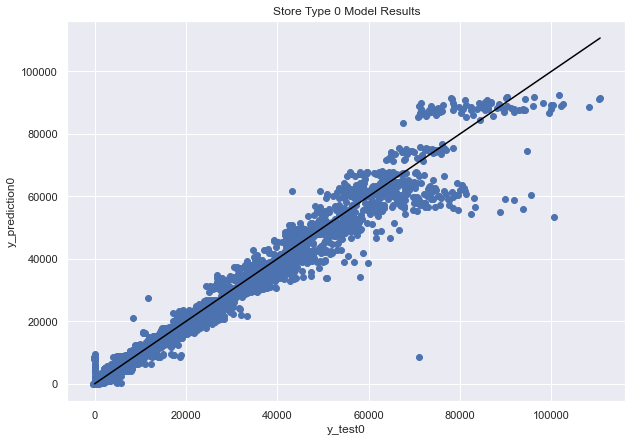

In [82]:
# Store Type 0
print('Store Type 0 Model Results')
print('R2 training score = ' + str(round(model0.score(X_train0, y_train0), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test0, y_pred0), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test0, y_pred0, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test0), y_pred0)
_ = plt.plot([1, y_test0.max()], [1, y_test0.max()], c='black')
plt.xlabel('y_test0')
plt.ylabel('y_prediction0')
plt.title('Store Type 0 Model Results')
_ = plt.show()

Store Type 1 Model Results
R2 training score = 0.9372
R2 testing score = 0.8488
Root-mean-squared test score = 6157.0


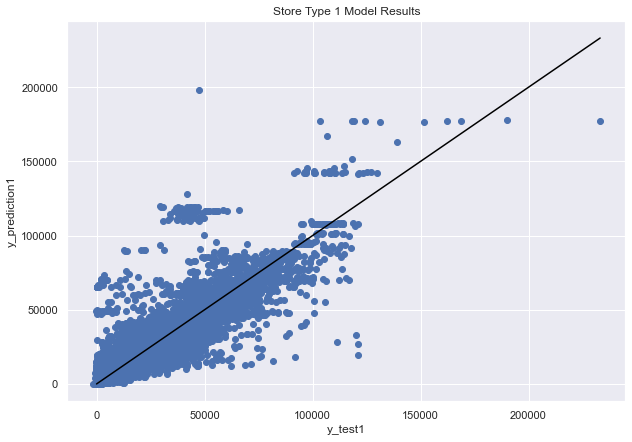

In [41]:
# Store Type 1
print('Store Type 1 Model Results')
print('R2 training score = ' + str(round(model1.score(X_train1, y_train1), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test1, y_pred1), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test1, y_pred1, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test1), y_pred1)
_ = plt.plot([1, y_test1.max()], [1, y_test1.max()], c='black')
plt.xlabel('y_test1')
plt.ylabel('y_prediction1')
plt.title('Store Type 1 Model Results')
_ = plt.show()

Store Type 2 Model Results
R2 training score = 0.9935
R2 testing score = 0.9377
Root-mean-squared test score = 6506.0


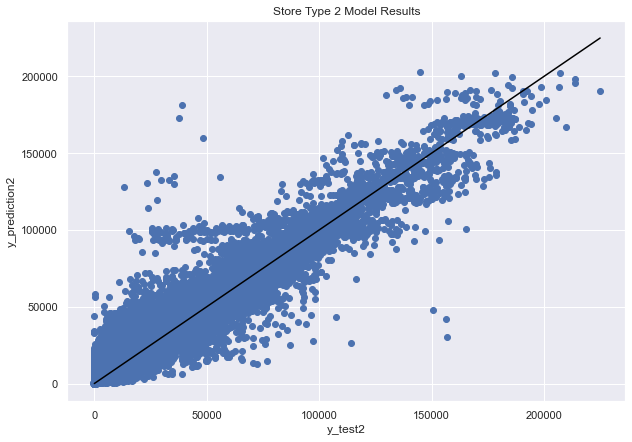

In [80]:
# Store Type 2

print('Store Type 2 Model Results')
print('R2 training score = ' + str(round(model2.score(X_train2, y_train2), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test2, y_pred2), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test2, y_pred2, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test2), y_pred2)
_ = plt.plot([1, y_test2.max()], [1, y_test2.max()], c='black')
plt.xlabel('y_test2')
plt.ylabel('y_prediction2')
plt.title('Store Type 2 Model Results')
_ = plt.show()